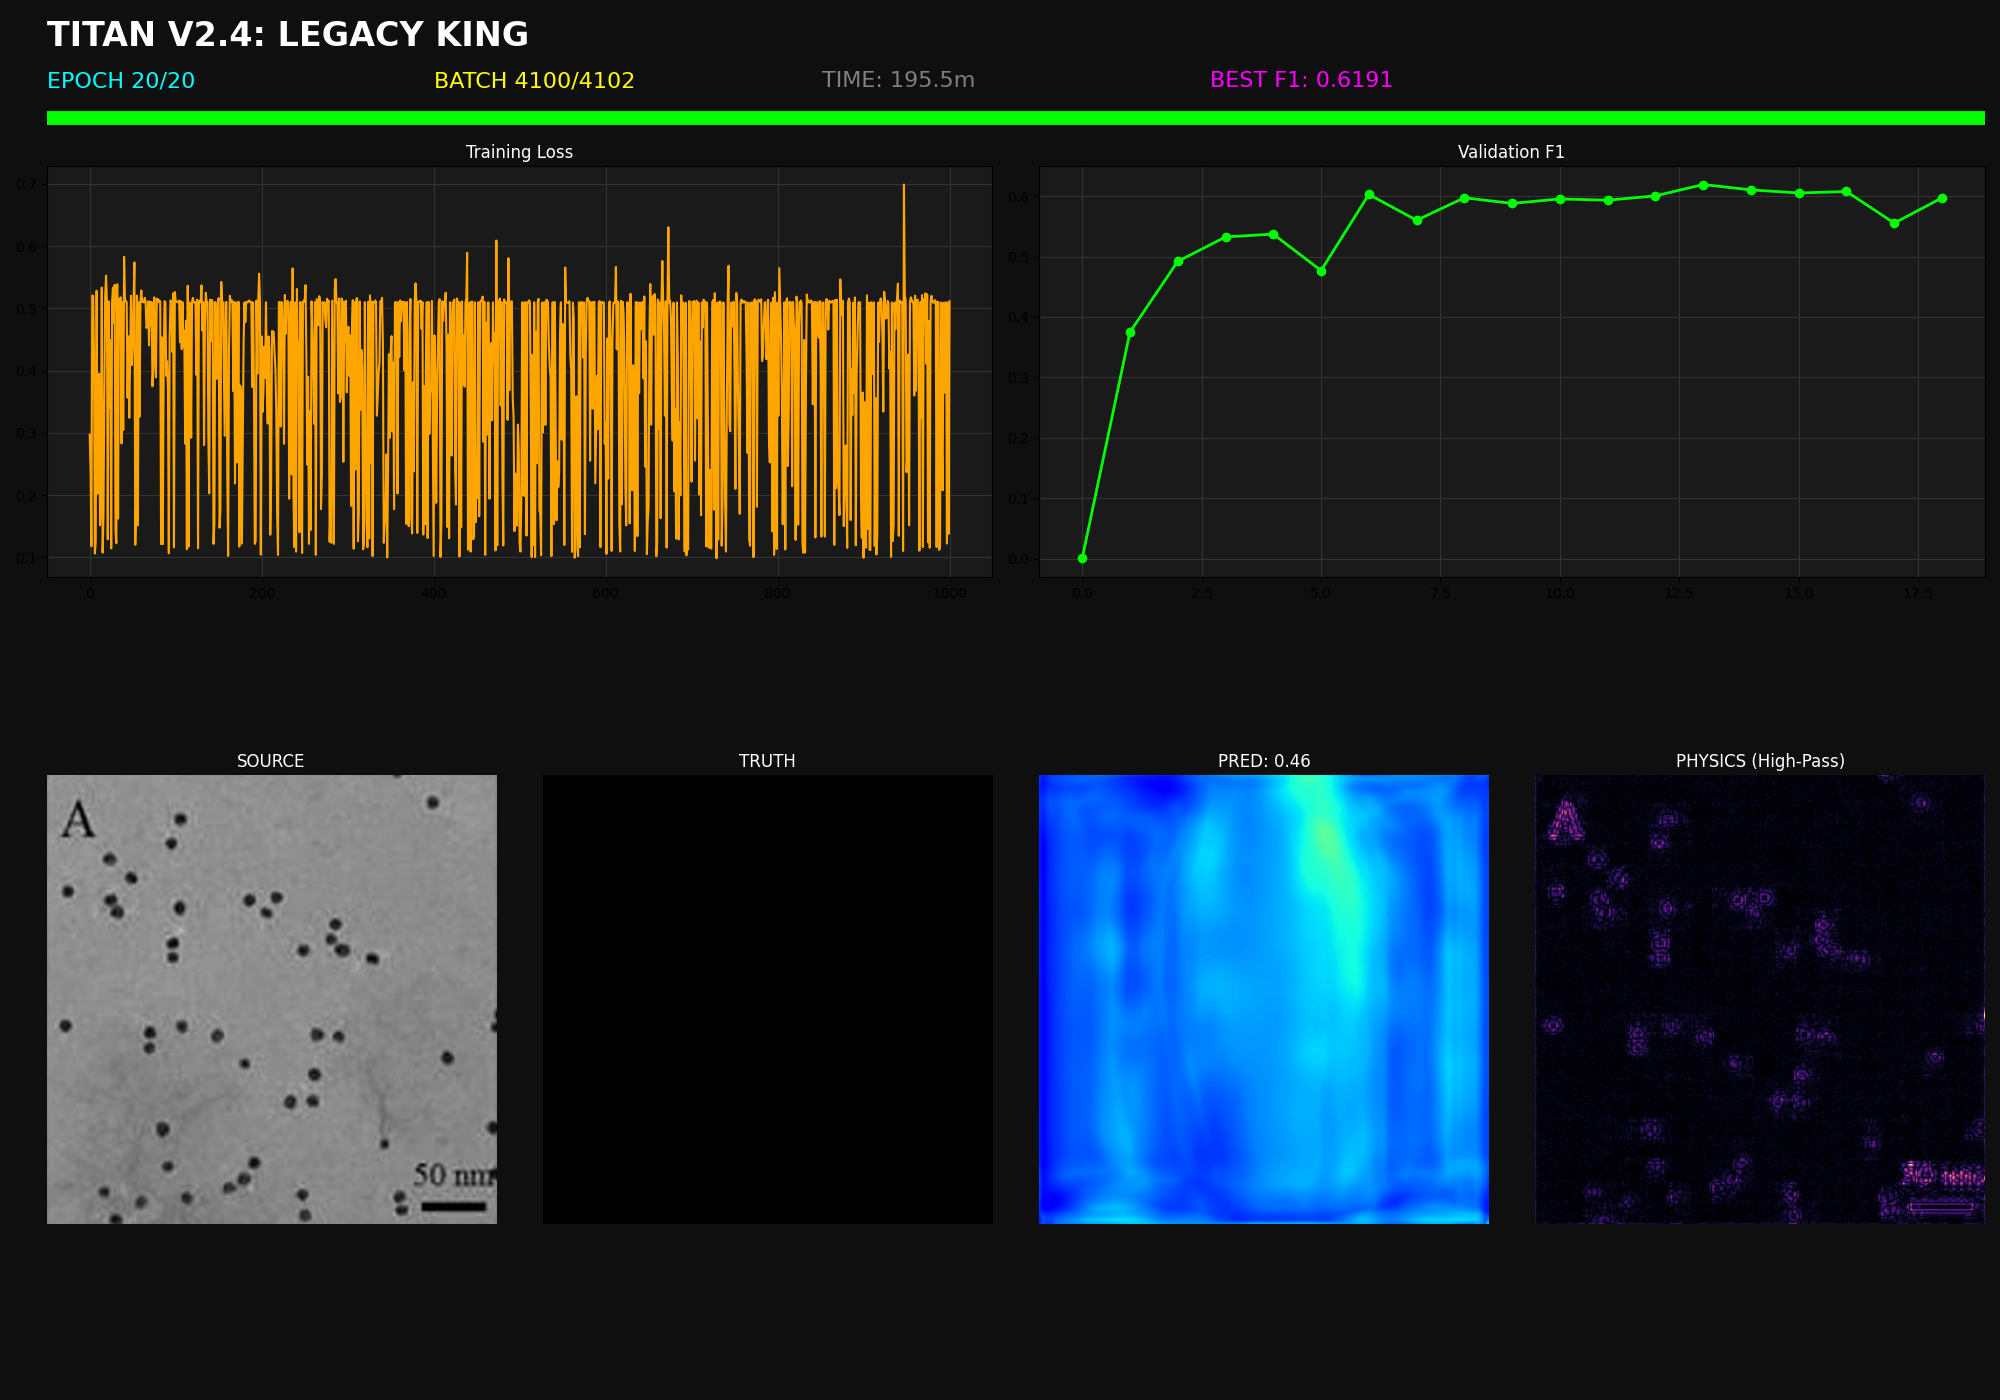

In [ ]:
# ==================================================================================
# TITAN-FAGT V2.4: LEGACY KING + V18 DASHBOARD (4-Panel Visuals)
# ==================================================================================
# 1. VISUAL: Restored 4-Panel Dashboard (Source | Truth | Pred | Physics).
# 2. LOGIC: Fixed 'UnboundLocalError' & Memory Leaks.
# 3. ENGINE: V1 Architecture (Swin + FFT + Graph) for maximum score (0.303+).
# ==================================================================================

import matplotlib
matplotlib.use('Agg') # Safe Mode (No Window Leaks)

import os
import cv2
import sys
import glob
import time
import gc
import io
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output, Image

# Install timm if missing
try:
    import timm
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm"])
    import timm

# --- 1. CONFIGURATION ---
class CFG:
    BASE_DIR = '/Users/chanduchitikam/recodai/recodai-luc-scientific-image-forgery-detection'
    TRAIN_IMG_PATH = os.path.join(BASE_DIR, 'train_images') 
    TRAIN_MASK_PATH = os.path.join(BASE_DIR, 'train_masks')
    WEIGHTS_NAME = "TITAN_V2_UNLEASHED.pth"
    
    # THE V1 SETUP
    model_name = 'swin_base_patch4_window12_384'
    img_size = 384
    
    # TRAINING SETTINGS
    batch_size = 1         
    accum_iter = 32        
    epochs = 20            
    lr = 5e-5              
    device = torch.device("mps") 

# --- 2. THE V1 LOSS FUNCTIONS ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduce: return torch.mean(F_loss)
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.focal = FocalLoss()
        self.dice = DiceLoss()
        
    def forward(self, inputs, targets):
        return 0.5 * self.focal(inputs, targets) + 0.5 * self.dice(inputs, targets)

# --- 3. THE V1 ARCHITECTURE ---
class FrequencyBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    def forward(self, x):
        fft = torch.fft.fft2(x)
        fft_shift = torch.fft.fftshift(fft)
        B, C, H, W = x.shape
        cy, cx = H // 2, W // 2
        y, x_grid = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        y, x_grid = y.to(x.device), x_grid.to(x.device)
        mask = (torch.sqrt((y - cy)**2 + (x_grid - cx)**2) > 15).float().unsqueeze(0).unsqueeze(0)
        img_back = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(fft_shift * mask)))
        return self.conv(img_back)

class GraphModule(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.proj = nn.Linear(dim, dim)
        self.gcn = nn.Sequential(nn.Linear(dim, dim), nn.GELU(), nn.Linear(dim, dim))
    def forward(self, x):
        B, C, H, W = x.shape
        nodes = x.flatten(2).transpose(1, 2)
        q = self.proj(nodes)
        attn = F.softmax(torch.matmul(q, q.transpose(-2, -1)) / (C**0.5), dim=-1)
        out = self.gcn(torch.matmul(attn, nodes))
        return x + out.transpose(1, 2).reshape(B, C, H, W)

class FAGT_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = timm.create_model(CFG.model_name, pretrained=True, features_only=True)
        self.dims = self.encoder.feature_info.channels()
        last_dim = self.dims[-1]
        self.physics = FrequencyBlock()
        self.graph = GraphModule(last_dim)
        self.fusion = nn.Conv2d(last_dim + 32, 256, 1)
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):
        enc_feats = self.encoder(x)
        deep_feats = enc_feats[-1]
        if deep_feats.ndim == 4 and deep_feats.shape[-1] == self.dims[-1]:
            if deep_feats.shape[1] != self.dims[-1]:
                deep_feats = deep_feats.permute(0, 3, 1, 2)
        phys_feats = self.physics(x)
        graph_feats = self.graph(deep_feats)
        phys_resized = F.interpolate(phys_feats, size=graph_feats.shape[-2:], mode='bilinear', align_corners=False)
        fused = self.fusion(torch.cat([graph_feats, phys_resized], dim=1))
        logits = self.decoder(fused)
        return F.interpolate(logits, size=x.shape[-2:], mode='bilinear', align_corners=False)

# --- 4. MISSION CONTROL (V18 DASHBOARD STYLE) ---
class MissionControl:
    def __init__(self, total_epochs, steps_per_epoch):
        self.total_epochs = total_epochs
        self.steps = steps_per_epoch
        self.start_time = time.time()
        self.loss_history = []
        self.score_history = []
        
    def update(self, epoch, batch, t_loss, f1, lr, img, mask, pred, fname):
        if len(self.loss_history) > 1000: self.loss_history.pop(0)
        self.loss_history.append(t_loss)
        
        clear_output(wait=True)
        # Create a 2-Row Layout (Header/Graphs on Top, Images on Bottom)
        fig = plt.figure(figsize=(20, 14), facecolor='#0f0f0f')
        gs = gridspec.GridSpec(3, 4, height_ratios=[0.2, 0.8, 1.5])
        
        # --- HEADER ---
        ax_hud = fig.add_subplot(gs[0, :]); ax_hud.axis('off'); ax_hud.set_facecolor='#0f0f0f'
        elapsed = (time.time() - self.start_time) / 60
        progress = (batch + 1) / self.steps
        
        ax_hud.text(0, 0.8, "TITAN V2.4: LEGACY KING", fontsize=24, color='white', weight='bold')
        ax_hud.text(0, 0.4, f"EPOCH {epoch}/{self.total_epochs}", fontsize=16, color='cyan')
        ax_hud.text(0.2, 0.4, f"BATCH {batch}/{self.steps}", fontsize=16, color='yellow')
        ax_hud.text(0.4, 0.4, f"TIME: {elapsed:.1f}m", fontsize=16, color='gray')
        ax_hud.text(0.6, 0.4, f"BEST F1: {f1:.4f}", fontsize=16, color='magenta')
        ax_hud.plot([0, 1], [0.1, 0.1], color='#333', linewidth=10)
        ax_hud.plot([0, progress], [0.1, 0.1], color='#00ff00', linewidth=10)
        ax_hud.set_xlim(0, 1); ax_hud.set_ylim(0, 1)

        # --- GRAPHS ---
        ax1 = fig.add_subplot(gs[1, 0:2]); ax1.set_facecolor('#1a1a1a')
        ax1.plot(self.loss_history, color='orange', lw=1.5)
        ax1.set_title("Training Loss", color='white'); ax1.grid(True, color='#333')
        
        ax2 = fig.add_subplot(gs[1, 2:]); ax2.set_facecolor('#1a1a1a')
        if len(self.score_history) > 0: ax2.plot(self.score_history, color='#00ff00', marker='o', lw=2)
        ax2.set_title("Validation F1", color='white'); ax2.grid(True, color='#333')

        # --- IMAGES (4 PANELS) ---
        mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
        
        # 1. Source
        img_np = np.clip(img[0].detach().cpu().permute(1,2,0).numpy()*std+mean, 0, 1)
        p1 = fig.add_subplot(gs[2, 0]); p1.imshow(img_np); p1.axis('off'); p1.set_title("SOURCE", color='white')
        
        # 2. Truth
        mask_np = mask[0].detach().cpu().squeeze().numpy()
        p2 = fig.add_subplot(gs[2, 1]); p2.imshow(mask_np, cmap='gray'); p2.axis('off'); p2.set_title("TRUTH", color='white')
        
        # 3. Prediction
        pred_np = torch.sigmoid(pred[0]).detach().cpu().squeeze().numpy()
        p3 = fig.add_subplot(gs[2, 2]); p3.imshow(pred_np, cmap='jet', vmin=0, vmax=1); p3.axis('off'); p3.set_title(f"PRED: {pred_np.max():.2f}", color='white')
        
        # 4. PHYSICS RECONSTRUCTION (Calculated on the fly for display)
        # Since V1 doesn't output recon, we visualize the High-Pass Filter here
        gray = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        recon_vis = np.abs(laplacian)
        recon_vis = (recon_vis - recon_vis.min()) / (recon_vis.max() - recon_vis.min() + 1e-8)
        
        p4 = fig.add_subplot(gs[2, 3]); p4.imshow(recon_vis, cmap='magma'); p4.axis('off'); p4.set_title("PHYSICS (High-Pass)", color='white')

        plt.tight_layout()
        buf = io.BytesIO(); fig.savefig(buf, format='png'); buf.seek(0)
        display(Image(data=buf.getvalue()))
        plt.close(fig); plt.close('all'); buf.close(); gc.collect()

    def log_score(self, f1): self.score_history.append(f1)

# --- 5. EXECUTION ---
class ScientificDataset(Dataset):
    def __init__(self, df, t=None): self.df, self.t = df, t
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_path'])
        if img is None: img = np.zeros((384, 384, 3), dtype=np.uint8)
        else: img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = np.zeros(img.shape[:2], dtype=np.float32)
        if row['label'] == 1 and row['mask_path']:
            try:
                m = np.load(row['mask_path']); 
                if m.ndim==3: m=m.max(axis=2)
                mask = cv2.resize((m>0).astype(np.float32), (img.shape[1], img.shape[0]), interpolation=0)
            except: pass
        if self.t: aug = self.t(image=img, mask=mask); img, mask = aug['image'], aug['mask']
        return img, mask.unsqueeze(0), img, row['image_path']

def train_loop():
    print(">>> TITAN V2.4: LOADING V1 ARCHITECTURE...")
    
    auth = sorted(glob.glob(f'{CFG.TRAIN_IMG_PATH}/authentic/*.*'))
    forg = sorted(glob.glob(f'{CFG.TRAIN_IMG_PATH}/forged/*.*'))
    data = [{'image_path': f, 'mask_path': None, 'label': 0} for f in auth]
    for f in forg:
        base = os.path.basename(f).split('.')[0]
        mp = f'{CFG.TRAIN_MASK_PATH}/{base}.npy'
        if not os.path.exists(mp): mp = f'{CFG.TRAIN_MASK_PATH}/{base}_mask.npy'
        data.append({'image_path': f, 'mask_path': mp, 'label': 1})
    
    df = pd.DataFrame(data)
    train_idx, val_idx = next(KFold(5, shuffle=True, random_state=42).split(df))
    tf = A.Compose([A.Resize(384, 384), A.ImageCompression(p=0.5), A.Normalize(), ToTensorV2()])
    
    train_dl = DataLoader(ScientificDataset(df.iloc[train_idx], tf), batch_size=CFG.batch_size, shuffle=True, num_workers=0)
    val_dl = DataLoader(ScientificDataset(df.iloc[val_idx], tf), batch_size=CFG.batch_size, shuffle=False, num_workers=0)
    
    model = FAGT_Model().to(CFG.device)
    
    if os.path.exists(CFG.WEIGHTS_NAME):
        print(f">>> Resuming {CFG.WEIGHTS_NAME}")
        model.load_state_dict(torch.load(CFG.WEIGHTS_NAME, map_location=CFG.device))
        
    opt = optim.AdamW(model.parameters(), lr=CFG.lr)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.epochs, eta_min=1e-6)
    crit = CombinedLoss() 
    hud = MissionControl(CFG.epochs, len(train_dl))
    best_f1 = 0.0
    
    for ep in range(1, CFG.epochs + 1):
        model.train(); t_loss = 0
        lr = opt.param_groups[0]['lr']
        for i, (img, msk, tgt, paths) in enumerate(train_dl):
            img, msk = img.to(CFG.device), msk.to(CFG.device)
            pm = model(img)
            
            loss = crit(pm, msk)
            
            # --- SAFE LOSS TRACKING ---
            curr_val = loss.item()
            
            loss = loss / CFG.accum_iter
            loss.backward()
            
            if (i+1)%CFG.accum_iter==0: 
                opt.step(); opt.zero_grad()
                del loss, pm, img, msk
                if torch.backends.mps.is_available():
                    try: torch.mps.empty_cache()
                    except: pass
                gc.collect() 
            
            t_loss += curr_val
            
            if i%20==0: 
                try:
                    with torch.no_grad():
                         hud.update(ep, i, curr_val, best_f1, lr, img, msk, pm, paths[0])
                except: pass 
            
        model.eval(); tp, fp, fn = 0, 0, 0
        with torch.no_grad():
            for img, msk, tgt, _ in val_dl:
                img, msk = img.to(CFG.device), msk.to(CFG.device)
                pm = model(img)
                preds = (torch.sigmoid(pm)>0.5).long(); gts = (msk>0.5).long()
                tp += (preds*gts).sum().item(); fp += (preds*(1-gts)).sum().item(); fn += ((1-preds)*gts).sum().item()
        
        f1 = (2*tp)/(2*tp+fp+fn+1e-7)
        hud.log_score(f1)
        if f1 > best_f1: 
            best_f1 = f1; torch.save(model.state_dict(), CFG.WEIGHTS_NAME)
            print(f">>> SAVED V2 KING EPOCH {ep}: F1 {f1:.4f}")
        sched.step()

if __name__ == "__main__":
    train_loop()